# 14. 아이유팬이 좋아할 만한 다른 아티스트 찾기

## 14-9. 프로젝트 - Movielens 영화 추천 실습

---

## 목차
- 1) 데이터 준비와 전처리
    - 추천 시스템의 MNIST 라고 부를만한 Movielens 데이터 사용
        - 유저가 영화에 대해 평점을 매긴 데이터: [Movielens 1M Dataset](https://grouplens.org/datasets/movielens/1m/)
        - 데이터 설명: [MovieLens 1M Dataset README.txt](https://files.grouplens.org/datasets/movielens/ml-1m-README.txt)
    - 별점 데이터: explicit 데이터
        - implicit 데이터로 간주하고 테스트해 볼 수 있음
    - 별점 == 시청횟수
    - 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외
- 2) 분석해 봅시다.
- 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.
- 4) CSR matrix를 직접 만들어 봅시다.
- 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.
- 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.
- 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.
- 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

---

### 1) 데이터 준비와 전처리

#### 1. 기본 데이터(평점) 불러오기: Movielens 데이터 `rating.dat` (UserID::MovieID::Rating::Timestamp)
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
rating_file_path='recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


- 원본 기본 데이터 보관

In [3]:
ratings_orig = ratings.copy()
ratings_orig_size = len(ratings)
print(ratings_orig_size)

1000209


- 유저별 컬럼에 대한 통계 확인

In [4]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count_orig = ratings_orig.groupby('user_id')['movie_id'].count()
user_count_orig.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movie_id, dtype: float64

In [5]:
# 유저별 시청횟수 중앙값에 대한 통계
user_median_orig = ratings_orig.groupby('user_id')['ratings'].median()
user_median_orig.describe()

count    6040.000000
mean        3.840811
std         0.577449
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: ratings, dtype: float64

- 별점 개수(ratings)와 사용자 수(users) 관계 막대그래프

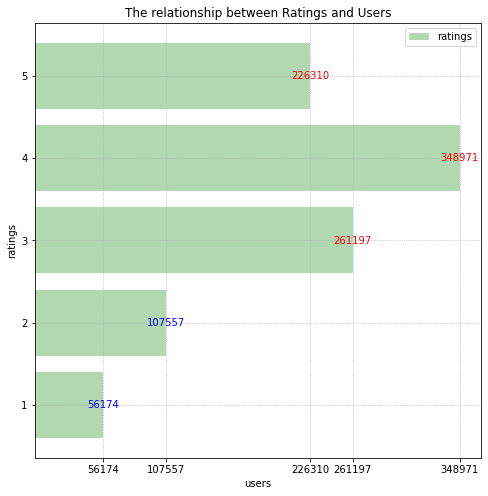

In [6]:
ratings_users = ratings.groupby(by=['ratings']).agg({'user_id': 'count'}).reset_index()
ratings_users.columns = ['ratings', 'users']
ratings_users_dic = {ratings:users for ratings, users in zip(ratings_users.ratings, ratings_users.users)}

plt.figure(figsize=(8,8))
plt.barh(ratings_users.ratings, ratings_users.users, align='center', alpha=0.3, color='g')
plt.yticks(ratings_users.ratings)
plt.xticks(ratings_users.users)
plt.legend(ratings_users.columns)
plt.ylabel('ratings')
plt.xlabel('users')
plt.grid(ls='dotted')
plt.title('The relationship between Ratings and Users')

for i, users in enumerate(ratings_users.users):
    if i >= 2:
        color = 'r'
    else:
        color = 'b'
    plt.text(users+i,1+i,users, horizontalalignment='center', verticalalignment='center', color=color)

plt.show()

- 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

In [7]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [8]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings['counts']

C:\Python\Anaconda3\envs\aiffel_3.8\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

- 유저별 컬럼에 대한 통계 확인

In [9]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [10]:
# 유저별 시청횟수 중앙값에 대한 통계
user_median = ratings.groupby('user_id')['counts'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: counts, dtype: float64

- Convert timestamp to datetime with pandas [[참고]](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
    - pd.to_datetime(arg, unit='s') => year-month-day hh:mm:ss
        - arg: int, float, str, datetime, list, tuple, 1-d array, Series, DataFrame/dict-like
        - unit: str, default ‘ns’ (D,s,ms,us,ns)

In [11]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings

C:\Users\User\AppData\Local\Temp\ipykernel_28036\2721094061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')


,user_id,movie_id,counts,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000203,6040,1090,3,2000-04-26 02:18:38
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


- 데이터 확인

In [12]:
# 결측치 확인
ratings.isna().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
dtype: int64

In [13]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    836478 non-null  int64         
 1   movie_id   836478 non-null  int64         
 2   counts     836478 non-null  int64         
 3   timestamp  836478 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 31.9 MB


- 첫 번째 유저가 어떤 영화를 봤는지 확인

In [14]:
ratings_user_1 = (ratings['user_id']==ratings.loc[0, 'user_id'])
movies_user_1 = ratings.loc[ratings_user_1]
print(f'user_1 이 시청한 영화 개수: {len(movies_user_1)}')
movies_user_1

user_1 이 시청한 영화 개수: 53


,user_id,movie_id,counts,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59
8,1,594,4,2000-12-31 22:37:48
9,1,919,4,2000-12-31 22:22:48


#### 2. 메타 데이터(영화) 불러오기: Movielens 데이터 `movies.dat` (MovieID::Title::Genres)
- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres: Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [15]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path='recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


- 원본 메타 데이터 보관

In [16]:
movies_orig = movies.copy()
movies_orig_size = len(movies)
print(movies_orig_size)

3883


- 데이터 확인

In [17]:
# 결측치 확인
movies.isna().sum()

movie_id    0
title       0
genre       0
dtype: int64

In [18]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


- 데이터 합치기 [[참고1]](https://yganalyst.github.io/data_handling/Pd_12/) [[참고2]](https://www.delftstack.com/ko/howto/python-pandas/pandas-groupby-count-python/)

In [19]:
# ratings 와 movies 데이터 프레임 합치기
ratings = ratings.join(movies.set_index('movie_id'), on='movie_id')
ratings.head(10)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,2000-12-31 22:37:48,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,2000-12-31 22:33:59,Ben-Hur (1959),Action|Adventure|Drama
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama
8,1,594,4,2000-12-31 22:37:48,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1,919,4,2000-12-31 22:22:48,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


- 첫 번째 유저(user_id == 1)가 시청한 영화 정보 확인

In [20]:
movies_detail_user_1 = ratings[ratings['user_id']==1]
print(f'user_1 이 시청한 영화 개수: {len(movies_detail_user_1)}')
movies_detail_user_1

user_1 이 시청한 영화 개수: 53


,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,2000-12-31 22:37:48,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,2000-12-31 22:33:59,Ben-Hur (1959),Action|Adventure|Drama
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama
8,1,594,4,2000-12-31 22:37:48,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1,919,4,2000-12-31 22:22:48,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


- 유저별 시청 영화 개수 그래프

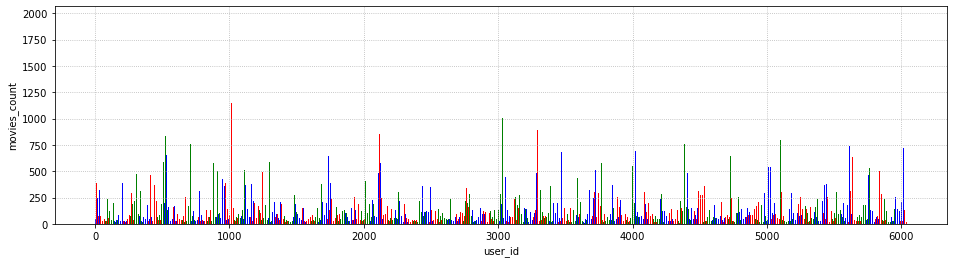

In [21]:
user_counts = ratings.groupby(by=['user_id']).agg({'movie_id': 'count'}).reset_index()
user_counts.columns = ['user_id', 'movies_count']

plt.figure(figsize=(16,4))
plt.bar(user_counts.user_id, user_counts.movies_count, color=['r','g','b'])
plt.xlabel('user_id')
plt.ylabel('movies_count')
plt.grid(ls='dotted')
plt.show()

In [22]:
top_30 = user_counts.sort_values(by=['movies_count'], ascending=False).head(30)
top_30

,user_id,movies_count
4167,4169,1968
4275,4277,1715
1679,1680,1515
3616,3618,1146
1014,1015,1145
5829,5831,1136
2908,2909,1119
1940,1941,1116
423,424,1106
1979,1980,1054


In [23]:
bottom_30 = user_counts.sort_values(by=['movies_count'], ascending=True).head(30)
bottom_30

,user_id,movies_count
4484,4486,1
4347,4349,7
4634,4636,9
4363,4365,9
1101,1102,9
4054,4056,9
940,941,10
5848,5850,11
5826,5828,11
3640,3642,11


### 2) 분석해 봅시다.
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

#### ratings에 있는 유니크한 영화 개수

In [24]:
# 영화 개수
ratings['movie_id'].nunique()

3628

#### ratings에 있는 유니크한 사용자 수

In [25]:
# 사용자 수
ratings['user_id'].nunique()

6039

#### 가장 인기 있는 영화 30개(인기순)

In [26]:
# 인기 많은 영화 내림차순 30개
movie_count = ratings.groupby(by=['movie_id', 'title'])['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id  title                                                
2858      American Beauty (1999)                                   3211
260       Star Wars: Episode IV - A New Hope (1977)                2910
1196      Star Wars: Episode V - The Empire Strikes Back (1980)    2885
1210      Star Wars: Episode VI - Return of the Jedi (1983)        2716
2028      Saving Private Ryan (1998)                               2561
589       Terminator 2: Judgment Day (1991)                        2509
593       Silence of the Lambs, The (1991)                         2498
1198      Raiders of the Lost Ark (1981)                           2473
1270      Back to the Future (1985)                                2460
2571      Matrix, The (1999)                                       2434
480       Jurassic Park (1993)                                     2413
2762      Sixth Sense, The (1999)                                  2385
608       Fargo (1996)                                             2371


### 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

- 모델 검증 위한 사용자 초기 정보 세팅
    - 추천 시스템은 처음 가입하는 사용자의 취향과 유사한 영화 정보를 5개 이상 입력받아야 함
    - 좋아하는 영화를 기존의 데이터에 추가하기
        - user_id: 6041  # user.dat 의 마지막 번호가 6040 이므로 추가할 user_id 값은 6041 로 설정
        - movie_id: my_favorite.keys()  # {movie_id: movie_title} 형태의 dictionary 라서 .keys()로 입력
            - movie_id 여야 제대로 동작함! 기존의 데이터에서 영화를 골랐기 때문!
            - movie_title 로 입력할 경우 새로운 인덱싱이 되므로 기존의 데이터에 있는 영화와 다르게 취급됨!

In [27]:
# 영화 제목으로 장르 추출하는 함수
def get_genre_of_movie(my_favorite):
    genres_of_my_favorite = []
    for k, v in my_favorite.items():
        genres_of_my_favorite.extend(movies[movies['title'] == v]['genre'].to_list())
    return genres_of_my_favorite

In [28]:
# 현재 시간
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# 영화 데이터 추가! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요.
my_favorite = {
    70: "From Dusk Till Dawn (1996)",
    164: "Devil in a Blue Dress (1995)",
    293: "Professional, The (a.k.a. Leon: The Professional) (1994)",
    426: "Body Snatchers (1993)",
    3476: "Jacob's Ladder (1990)",
}

# 6041이라는 user_id가 위 영화를 counts회씩 시청했다고 가정하겠습니다.
my_playlist = pd.DataFrame({
    'user_id': [6041]*5,
    'movie_id': my_favorite.keys(),
    'counts': [3,4,4,5,5],
    'timestamp': [now]*5,
    'title': my_favorite.values(),
    'genre': get_genre_of_movie(my_favorite)
})

if not ratings.isin({'user_id':[6041]})['user_id'].any():  # user_id에 6041이라는 데이터가 없다면
    ratings = ratings.append(my_playlist)  # my_favorite 데이터 추가

ratings.tail(10)  # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts,timestamp,title,genre
1000203,6040,1090,3,2000-04-26 02:18:38,Platoon (1986),Drama|War
1000205,6040,1094,5,2000-04-25 23:21:27,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,2000-04-25 23:19:06,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,2000-04-26 02:20:48,Sophie's Choice (1982),Drama
1000208,6040,1097,4,2000-04-26 02:19:29,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,6041,70,3,2022-03-02 13:06:25,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
1,6041,164,4,2022-03-02 13:06:25,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
2,6041,293,4,2022-03-02 13:06:25,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
3,6041,426,5,2022-03-02 13:06:25,Body Snatchers (1993),Horror|Sci-Fi|Thriller
4,6041,3476,5,2022-03-02 13:06:25,Jacob's Ladder (1990),Horror|Mystery|Thriller


- 모델에 활용하기 위한 전처리
    - indexing: 데이터 user 와 movie 각각에 번호 붙이기
    - pandas.DataFrame.unique(): 특정 컬럼에 포함된 유니크한 데이터만 모아줌

In [30]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
# movie_unique = ratings['movie_id'].unique()
movie_unique = ratings['title'].unique()

# 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [31]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print('user_id indexing: {}\n'.format(user_to_idx[6041]))

for k, v in my_favorite.items():
    print('movie_id indexing: {}'.format(movie_to_idx[v]))

user_id indexing: 6039

movie_id indexing: 1034
movie_id indexing: 864
movie_id indexing: 890
movie_id indexing: 2361
movie_id indexing: 279


In [32]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_ratings = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_ratings) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_ratings   # ratings['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 movie 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
# temp_movie_ratings = ratings['movie_id'].map(movie_to_idx.get).dropna()
temp_movie_ratings = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_ratings) == len(ratings):
    print('movie column indexing OK!!')
    ratings['movie_id'] = temp_movie_ratings
else:
    print('movie column indexing Fail!!')

ratings.tail(10)

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,counts,timestamp,title,genre
1000203,6038,1030,3,2000-04-26 02:18:38,Platoon (1986),Drama|War
1000205,6038,986,5,2000-04-25 23:21:27,"Crying Game, The (1992)",Drama|Romance|War
1000206,6038,311,5,2000-04-25 23:19:06,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6038,142,4,2000-04-26 02:20:48,Sophie's Choice (1982),Drama
1000208,6038,26,4,2000-04-26 02:19:29,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,6039,1034,3,2022-03-02 13:06:25,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
1,6039,864,4,2022-03-02 13:06:25,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
2,6039,890,4,2022-03-02 13:06:25,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
3,6039,2361,5,2022-03-02 13:06:25,Body Snatchers (1993),Horror|Sci-Fi|Thriller
4,6039,279,5,2022-03-02 13:06:25,Jacob's Ladder (1990),Horror|Mystery|Thriller


- 데이터 확인

In [33]:
ratings.isna().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
title        0
genre        0
dtype: int64

In [34]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836483 entries, 0 to 4
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    836483 non-null  int64 
 1   movie_id   836483 non-null  int64 
 2   counts     836483 non-null  int64 
 3   timestamp  836483 non-null  object
 4   title      836483 non-null  object
 5   genre      836483 non-null  object
dtypes: int64(3), object(3)
memory usage: 44.7+ MB


- 시청횟수별 데이터의 비율

In [35]:
# 총 데이터 개수
all_data = len(ratings)
print(f'All data: {all_data}\n')

# n회 시청한 데이터의 비율을 보는 코드
view_counts = set(ratings['counts'])
ratio_list = []
for n in view_counts:
    only_num = ratings[ratings['counts']==n]
    len_only_num = len(only_num)  # n회 시청한 데이터 개수
    ratio = len_only_num/all_data
    ratio_list.append(ratio)

    print(f'Only {n} data: {len_only_num}, Ratio: {ratio:.2%}')

All data: 836483

Only 3 data: 261198, Ratio: 31.23%
Only 4 data: 348973, Ratio: 41.72%
Only 5 data: 226312, Ratio: 27.06%


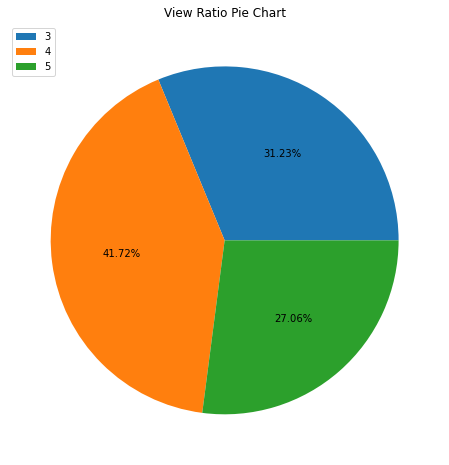

In [36]:
# 파이 차트 그리기
plt.figure(figsize=(8,8))
plt.pie(ratio_list, autopct='%.2f%%')
plt.title('View Ratio Pie Chart')
plt.legend(view_counts)
plt.show()

### 4) CSR matrix를 직접 만들어 봅시다.

In [37]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [38]:
csr_data.shape

(6040, 3628)

### 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.
- [AlternatingLeastSquares](https://implicit.readthedocs.io/en/latest/als.html) 클래스의 __init__ 파라미터
    - factors (int, optional): 유저와 아이템의 벡터를 몇 차원으로 할 것인지
    - regularization (float, optional): 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
    - dtype (data-type, optional)
    - use_native (bool, optional)
    - use_cg (bool, optional)
    - use_gpu (bool, optional): GPU를 사용할 것인지
    - iterations (int, optional): epochs와 같은 의미. 데이터를 몇 번 반복해서 학습할 것인지
    - calculate_training_loss (bool, optional)
    - num_threads (int, optional)
    - random_state (int, RandomState or None, optional)
- factors 와 iterations 를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 한다!
    - factors=300, iterations=15 으로 진행
- **cf. 패키지 설치 참고: 최신 implicit 패키지 버전이 0.5.2 인데 그거로 사용하면 에러가 발생하므로 삭제하고 lms 클라우드와 동일한 0.4.8 버전으로 설치해야 함!!!**
```bash
# implicit 패키지 버전 0.4.8로 설치해야 에러가 발생하지 않음!
pip install implicit==0.4.8

# 아나콘다 사용자일 경우 implicit 0.4.8 버전 설치 코드
conda install -c conda-forge implicit==0.4.8
```

In [39]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [40]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=300, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [41]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [42]:
csr_data_transpose.shape

(3628, 6040)

In [43]:
# 모델 훈련
als_model.fit(csr_data_transpose)

100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


### 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [44]:
user = user_to_idx[6041]
user_vector = als_model.user_factors[user]
user_vector  # 사용자 벡터

array([ 0.28502363, -0.4773997 , -0.29852918,  0.09017462,  0.5770129 ,
       -0.3109712 , -0.32419273, -0.3940362 ,  0.06030442,  0.5642371 ,
        0.5806169 ,  0.20155005,  0.37006274, -0.29308242, -1.004876  ,
        0.25679433, -0.2555344 ,  0.4708897 ,  0.17899644, -0.9408019 ,
        0.30086213, -0.13773172, -0.77067417, -0.43851626,  0.11563419,
       -0.04543833,  0.6713725 ,  0.3190956 ,  0.25819942, -0.1918004 ,
        0.15769635,  0.14883788, -0.2929961 , -0.32120237,  0.3486411 ,
       -0.1287454 ,  0.15549858, -0.29596835,  0.06204395, -0.23088716,
       -0.04355889, -0.38206118, -0.5246314 ,  0.14434431,  0.38958123,
        0.3309625 ,  0.72528696, -0.6280095 , -0.7455123 ,  0.28830937,
       -0.11558612,  0.24093689,  0.04729592, -0.09140401, -0.06136812,
       -0.59708786, -0.07929159,  0.28108752,  0.39470965, -0.2809593 ,
        0.3425197 , -0.24044625, -0.5262361 ,  0.5631618 ,  1.0396079 ,
        0.4421009 , -0.22549398,  0.11266248,  0.29615647,  0.32

In [45]:
star_wars_epi_4 = movie_to_idx['Star Wars: Episode IV - A New Hope (1977)']
star_wars_epi_4_vector = als_model.item_factors[star_wars_epi_4]
star_wars_epi_4_vector  # 영화 벡터

array([ 1.25756338e-02,  6.77220349e-04, -3.10079195e-03,  1.67911127e-02,
        2.65094149e-03, -1.36612765e-02,  1.21771768e-02, -1.44103244e-02,
        2.16685981e-03, -8.55445582e-03,  7.68906251e-03,  1.72433350e-02,
        8.05560034e-03,  1.49913980e-02, -1.75047871e-02,  5.74991666e-03,
       -1.93641502e-02,  5.22461766e-03, -3.16584297e-02, -9.34082177e-03,
        1.63117275e-02,  1.15973298e-02, -6.07063528e-03,  6.02732354e-04,
        1.56719983e-02,  2.29272917e-02,  3.39963324e-02,  1.74624491e-02,
        3.14054720e-04, -3.63196270e-03, -1.32214166e-02,  2.04146048e-03,
       -2.15351637e-02,  1.09737786e-02,  1.82446018e-02,  2.44474392e-02,
       -2.10786164e-02, -5.17288968e-03, -5.98888006e-03,  1.06463004e-02,
        1.27985636e-02,  8.13888106e-03,  3.33775468e-02, -6.70570647e-03,
        3.51851340e-03,  1.66506637e-02, -2.49175238e-03,  9.50514711e-03,
        2.01143622e-02,  1.75296341e-03,  1.14870276e-02, -2.42099632e-03,
       -1.60673410e-02, -

In [46]:
# user와 star_wars_epi_4를 내적하는 코드
np.dot(user_vector, star_wars_epi_4_vector)

-0.052471306

In [47]:
toy_story_2 = movie_to_idx['Toy Story 2 (1999)']
toy_story_2_vector = als_model.item_factors[toy_story_2]
np.dot(user_vector, toy_story_2_vector)

-0.040521607

In [48]:
def predict_my_preference(user_vector, title, print_flag=True):
    movie = movie_to_idx.get(title, 0)
    movie_vector = als_model.item_factors[movie]

    # user_vector와 movie_vector를 내적하는 코드
    dot_user_movie = np.dot(user_vector, movie_vector)
    if print_flag:
        print(f'* user_vector 와 movie_vector({title}) 를 내적한 결과: {dot_user_movie:.2f}')
    else:
        return round(dot_user_movie, 2)

In [49]:
predict_my_preference(user_vector, 'Toy Story 2 (1999)')

* user_vector 와 movie_vector(Toy Story 2 (1999)) 를 내적한 결과: -0.04


In [50]:
for movie_id, movie_title in my_favorite.items():
    predict_my_preference(user_vector, movie_title)

* user_vector 와 movie_vector(From Dusk Till Dawn (1996)) 를 내적한 결과: 0.46
* user_vector 와 movie_vector(Devil in a Blue Dress (1995)) 를 내적한 결과: 0.45
* user_vector 와 movie_vector(Professional, The (a.k.a. Leon: The Professional) (1994)) 를 내적한 결과: 0.71
* user_vector 와 movie_vector(Body Snatchers (1993)) 를 내적한 결과: 0.36
* user_vector 와 movie_vector(Jacob's Ladder (1990)) 를 내적한 결과: 0.62


- 영화 데이터에 선호도 컬럼 추가

In [51]:
my_prefer = []
for title in movies['title'].to_list():
    my_prefer.append(predict_my_preference(user_vector, title, False))

In [52]:
movies.insert(len(movies.columns), 'my_prefer', my_prefer, allow_duplicates=True)
movies

,movie_id,title,genre,my_prefer
0,1,Toy Story (1995),Animation|Children's|Comedy,-0.02
1,2,Jumanji (1995),Adventure|Children's|Fantasy,-0.01
2,3,Grumpier Old Men (1995),Comedy|Romance,-0.00
3,4,Waiting to Exhale (1995),Comedy|Drama,0.07
4,5,Father of the Bride Part II (1995),Comedy,-0.03
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,-0.02
3879,3949,Requiem for a Dream (2000),Drama,-0.03
3880,3950,Tigerland (2000),Drama,-0.03
3881,3951,Two Family House (2000),Drama,0.01


- 선호도 0.6 이상인 영화 목록

In [53]:
movies[movies['my_prefer'] >= 0.6]

,movie_id,title,genre,my_prefer
290,293,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller,0.71
3407,3476,Jacob's Ladder (1990),Horror|Mystery|Thriller,0.62


### 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [54]:
favorite_movie = 'Heavenly Creatures (1994)'
movie_title = movie_to_idx[favorite_movie]
similar_movies = als_model.similar_items(movie_title, N=15)
similar_movies

[(868, 1.0000001),
 (2415, 0.49513078),
 (1298, 0.4708036),
 (274, 0.46541053),
 (1768, 0.4537564),
 (2522, 0.45109302),
 (3217, 0.44895703),
 (313, 0.44810748),
 (2516, 0.4477871),
 (1934, 0.44736117),
 (3128, 0.4465272),
 (2934, 0.44625357),
 (3369, 0.4444599),
 (2552, 0.44382775),
 (2894, 0.443391)]

In [55]:
# movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movies]

['Heavenly Creatures (1994)',
 'Trust (1990)',
 'Flirt (1995)',
 'All Over Me (1997)',
 'Naked (1993)',
 'Mute Witness (1994)',
 'Zed & Two Noughts, A (1985)',
 'Nowhere (1997)',
 'Peeping Tom (1960)',
 'Doom Generation, The (1995)',
 'Cyclo (1995)',
 'Sleepaway Camp (1983)',
 'Cure, The (1995)',
 'Normal Life (1996)',
 'When Night Is Falling (1995)']

In [56]:
def get_similar_movie(movie_name: str):
    movie_title = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_title, N=15)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movies]
    return similar_movie

print("슝=3")

슝=3


In [57]:
get_similar_movie('Deep Impact (1998)')

['Heavenly Creatures (1994)',
 'Trust (1990)',
 'Flirt (1995)',
 'All Over Me (1997)',
 'Naked (1993)',
 'Mute Witness (1994)',
 'Zed & Two Noughts, A (1985)',
 'Nowhere (1997)',
 'Peeping Tom (1960)',
 'Doom Generation, The (1995)',
 'Cyclo (1995)',
 'Sleepaway Camp (1983)',
 'Cure, The (1995)',
 'Normal Life (1996)',
 'When Night Is Falling (1995)']

### 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [58]:
user = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(831, 0.2586314),
 (456, 0.20997207),
 (1368, 0.20478493),
 (1090, 0.18801789),
 (299, 0.18583962),
 (997, 0.18345392),
 (467, 0.1562444),
 (1070, 0.15528165),
 (855, 0.15031491),
 (1113, 0.14928639),
 (373, 0.14691266),
 (924, 0.14686173),
 (1450, 0.14364569),
 (814, 0.14088926),
 (174, 0.1408778),
 (93, 0.13864477),
 (1107, 0.13787723),
 (637, 0.13776878),
 (1200, 0.13414526),
 (239, 0.13218693)]

In [59]:
[idx_to_movie[i[0]] for i in movie_recommended]

["Devil's Advocate, The (1997)",
 'Arachnophobia (1990)',
 'Henry: Portrait of a Serial Killer (1990)',
 'Nikita (La Femme Nikita) (1990)',
 'Mariachi, El (1992)',
 'Scream (1996)',
 'Cape Fear (1991)',
 'Long Kiss Goodnight, The (1996)',
 'Grifters, The (1990)',
 'Dead Again (1991)',
 'Heat (1995)',
 'Dark City (1998)',
 'Big Kahuna, The (2000)',
 'Big Daddy (1999)',
 'Blade (1998)',
 'Alien: Resurrection (1997)',
 "Rosemary's Baby (1968)",
 'Abyss, The (1989)',
 'American President, The (1995)',
 'Faculty, The (1998)']

In [60]:
item_movie = movie_to_idx['Kansas City (1996)']
explain = als_model.explain(user, csr_data, itemid=item_movie)

In [61]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Devil in a Blue Dress (1995)', 0.013822216551633678),
 ("Jacob's Ladder (1990)", 0.0035887370886665804),
 ('Body Snatchers (1993)', 0.0034424099868628462),
 ('From Dusk Till Dawn (1996)', 0.0002720589646487189),
 ('Professional, The (a.k.a. Leon: The Professional) (1994)',
  -0.009198419141985924)]

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
초반에 lms 코드를 그대로 가져다 썼을 때, 이상하게 로컬에서도 코랩에서도 오류가 발생해서 화가 치밀었다. als_model 훈련이 끝나고 user_vector 를 구하기 위한 als_model.user_factors[user] 코드에서 에러가 발생했다. 아무리 생각해도 오류날 곳이 아닌데 거기서 막혀서 머리가 아팠다. 알고 보니 implicit 패키지 버전이 달라서 이런 일이 발생했던 것이었다.. ^^

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
1. 이해할 수 없는 오류가 가로막는다면 lms 클라우드 패키지와 똑같은 버전으로 설치해야 한다.
2. [implicit 라이브러리 0.4.8](https://implicit.readthedocs.io/en/latest/)
    - Fast Python Collaborative Filtering for Implicit Datasets
    - This project provides fast Python implementations of several different popular recommendation algorithms for implicit
3. [희소행렬(Sparse Matrix)](https://ko.wikipedia.org/wiki/%ED%9D%AC%EC%86%8C%ED%96%89%EB%A0%AC) <-> 밀집행렬(Dense Matrix)<br>![](https://wikimedia.org/api/rest_v1/media/math/render/svg/dbbd270e3e174daa36d9c2460211fe6f8569c0e6)
    - 행렬의 값이 대부분 0인 경우
    - 희소행렬의 자료구조 저장법: Dictonary of keys, LIL, COO, CSR or CRS, CSC or CCS
4. CSR Matrix<br>![](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cab70edf680e9e5ca0dea1a64890ac7ded25172)
    - 가로의 순서대로 재정렬하는 방법으로 행에 관여하여 정리 압축한 것
    - 행압축정보의 배열은 [최초시작행번호,시작행에서의 데이타 개수,두번째 행에서의 데이타 누적 개수,...,마지막행에서의 데이타 누적개수]
5. [추천 알고리즘](https://yeomko.tistory.com/3)
    - Contents Based Filtering
        - e.g. 사용자 혹은 아이템에 대한 프로필 데이터를 가지고 내가 좋아했던 아이템과 비슷한 유형의 아이템을 추천하거나 나와 비슷한 유형의 사람이 좋아하는 아이템을 추천
        - user-based recommendation, item-based recommendation
        - 단점: 데이터셋 구성하기 어려움(많은 시간, 비용), 주관성 개입 문제(=추천의 객관성 하락)
    - Collaborative Filtering
        - e.g. 내가 남긴 평점 데이터를 가지고 나와 취향이 비슷한 사람이 선호하는 아이템을 추천
        - Collaborative Filtering 문제를 푸는 세부 알고리즘: Matrix Factorization, Alternating Least Squares
        - 장점: 도메인 제약없이 데이터셋 쌓기 쉬움, Contents Based Filtering 보다 더 정확함
        - 단점: 신규 사용자의 경우 관찰된 행동 데이터가 적어서 추천 정확도가 급격히 떨어짐(=Cold start 문제)
    - Hybrid Filtering
        - e.g. 둘 다 문제가 있으니, 이 둘을 섞어서 사용해보자!
        - Combining Filtering 기법, Collaboration via Content 기법
6. [Collaborative Filtering](https://yeomko.tistory.com/6)
    - X축이 사용자, Y축이 아이템인 행렬로 표기가 가능<br>![](https://t1.daumcdn.net/cfile/tistory/9995253B5C8FC8EE06)
        - 주어진 평점 데이터 만으로 아직 평점을 남기지 않은 아이템들에 대한 평점을 예측하는 기법
        - 평점 데이터: Explicit Dataset, Implicit Dataset
            - Explicit Dataset
                - 선호와 비선호를 명확하게 구분해준 데이터 셋
                - ? 에 해당하는 데이터들을 제외한 평점 데이터 만으로 사용자의 선호도를 학습
                - Neighborhood 기법: 평점 데이터를 가지고 양의 선형 관계 혹은 음의 선형 관계를 계산
            - Implicit Dataset
                - 호불호 구분 없이 사용자가 아이템을 얼마나 소비하였는지를 기록한 데이터 셋
                - ? 에 해당하는 영역 역시 데이터로 포함하여 사용자의 선호도를 학습
                - Latent Factor Model: 관찰된 데이터와 잠재되어 있는 데이터를 연결시키는 기법
                    - 커다란 평점 행렬을 사용자와 아이템 Latent Factor로 분해하고, 이를 각각 학습시키는 Matrix Factorization 기법이 적합
7. [Matrix Factorization](https://yeomko.tistory.com/5)
    - 평점 행렬을 사용자와 아이템 Latent Factor 행렬로 분해<br>![](https://t1.daumcdn.net/cfile/tistory/99A2523D5C910CD90B)
        - R: 사용자가 아이템에 남긴 평점을 행렬로 나타낸 것
            - R의 크기 = 사용자 수(Nu) x 아이템의 수(Ni)
        - Nf: Matrix Factorization 학습 시에 정하는 임의의 차원 수
            - 개발자가 조정 가능 => 보통 50에서 200 사이로 설정
            - X와 Y는 사용자와 아이템의 Latent Factor 행렬을 나타냄 => 우리가 학습시키고자 하는 대상
            - 이 행렬들의 값은 아주 작은 랜덤한 값들로 초기화
        - xu: 사용자 특징 벡터(Nf x 1 크기의 열 벡터 (column vector)) => 특정 사용자의 Latent Vector
        - yi: 아이템 특징 벡터(Nf x 1 크기의 열 벡터 (column vector)) => 특정 아이템의 Latent Vector
    - 분해된 행렬을 다시 곱하여 예측 평점 행렬을 계산<br>![](https://t1.daumcdn.net/cfile/tistory/990FBA3A5C910D0A1A)
        - 평점 예측 행렬 = X 행렬의 전치행렬(Transpose) * Y 행렬
            - X 행렬의 전치행렬(Transpose) = Nu x Nf 크기 행렬
            - 평점 예측 행렬 = Nu x Ni 크기 행렬
        - 평점 계산 = 특정 사용자의 Latent Vector와 특정 아이템의 Latent Vector를 곱함
    - Loss Function
    - Optimization
        - Gradient Descent: loss를 미분하고, 여기에 learning rate를 곱한 다음 X와 Y 행렬의 값들을 업데이트 해주는 방식
        - Alternating Least Squares: X와 Y 둘 중 하나를 고정시키고 다른 하나를 최적화 -> 번갈아가며 반복 -> 짧은 시간 내에 최적의 X와 Y를 찾아냄
        - Non-convex problem(NP 문제)는 ALS 알고리즘이 적합하다.
8. [ALS(Alternating Least Square)]((https://yeomko.tistory.com/4))<br>![](https://miro.medium.com/max/1400/1*ezY_g30VQ8MTGpDwd3z56w.png)
    - 사용자와 아이템의 Latent Factor를 한번 씩 번갈아가며 학습<br>![](https://t1.daumcdn.net/cfile/tistory/997CAE475C8A5B7A04)
    - Loss Function: ![](https://t1.daumcdn.net/cfile/tistory/996B484C5C87DA353A)
    - 사용자 혹은 아이템의 Latent Factor 행렬을 아주 작은 랜덤 값으로 초기화 -> 둘 중 하나를 상수처럼 고정시켜 Loss Function을 Convex Function으로 생성 -> 미분한 다음, 미분 값을 0으로 만드는 사용자 혹은 아이템의 Latent Factor 행렬 계산 -> 이 과정을 사용자 한 번, 아이템 한 번 반복 -> 최적의 X, Y 찾기
    - 논문에서 설정한 반복 횟수 10 ~ 15번 => 데이터 양/Sparse 정도에 따라서 조절해야 함
    - [구현](https://yeomko.tistory.com/8) 단계: 학습 파라미터 초기화 -> 학습용 평점 데이터 설정 -> 사용자와 아이템의 Latent Factor Matrix 초기화, 선호도 행렬 P 설정 -> 신뢰도 행렬 C 설정 -> Loss Function 설정 -> Optimizer 설정 -> 학습 -> 학습 결과 분석 및 시각화
9. [추천 엔진 성능 지표](https://yeomko.tistory.com/32)
    - 추천 엔진 정확도 평가하기 위한 요소 2개: 순서(Ranking), 개인화(Personalization)
    - 성능 평가 지표: mAP, NDCG, Entropy Diversity 등
        - mAP(Mean Average Precision): recall의 값이 0부터 1까지 변화할 때 precision 값의 평균 값
        - nDCG(normalized Discounted Cumulative Gain): 추천의 순서에 더 가중치를 두어서 성능을 평가하는 지표, 1에 가까울수록 좋음
        - Entropy Diversity: 추천 결과의 다양성(=얼마나 분산되어 있는가)을 측정하는 지표
cf. 성능 평가 지표(Metrics)
    - Classification: accuracy, precision, recall, f1-score
    - Object Detection: mAP
    - Regression: r2-score


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|CSR matrix가 정상적으로 만들어졌다.|사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.|
>|2|MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.|사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.|
>|3|비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.|MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.|

CSR Matrix 를 사용자(user_id 유니크 개수: 6040)와 아이템 개수(movie_id 유니크 개수: 3628)를 바탕으로 만들었다. CSR Matrix 를 transpose 한 값을 als_model 을 훈련할 때 사용했다.

파라미터는 factors=500, iterations=30 으로 수정하고 나머지는 건드리지 않고 훈련을 진행했다. 사용자(user_id == 6041)와 아이템(movie_id) 벡터 내적수치를 각 영화마다 구해서 0.6 이상인 영화 목록을 출력해서 확인했다.

유저 선호도, 아이템간 유사도, 기여도를 측정해서 비슷한 영화를 찾아서 유저에게 추천해보았다. 


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
앞으로 LMS 클라우드에 설치된 패키지 버전과 똑같은 버전으로 설치해야 겠다.

---
- 대나무숲
    - lms 에서는 제대로 돌아가는 코드가 로컬과 코랩 모두 돌아가질 않아서 정말 미치는 줄 알았다!!! **als_model.user_factors[user] 이 코드가 자꾸 에러를 뿜어댔다.** 원인은 lms 클라우드에 설치된 implicit 패키지 버전(0.4.8)과 내가 설치한 implicit 패키지의 버전(0.5.2)이 똑같지 않아서 해당 코드가 말썽이었던 것이었다. **0.5.2 버전의 implicit 패키지를 삭제하고 0.4.8 버전으로 설치했더니 그 오류에서 벗어날 수 있었다.** 덕분에 나를 오늘도 분노로 가득차게 만들었다. 그거 해결하고 그래프 그려보다가 끝나버렸다. 다른 걸 시도해보지 못한 점이 아쉽지만 어쩔 수 없다.